In [1]:
from timm.data.transforms_factory import create_transform
import torchvision
from torch.utils.data import Dataset
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import timm
import torch
from sklearn.metrics import *
from tqdm import tqdm
import gc
import wandb
import os
import pandas as pd
import re
import torchaudio
import torch.nn as nn

BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


 
NOISE_DIR = '../input/realistic_noise/images/'
SIGNAL_DIR = '../input/pure_signal'
    
 
    
POSITIVE_RATE = 0.5
SIGNAL_LOW = 0.02
SIGNAL_HIGH = 0.10
EVAL_PCT = 0.2
DEBUG = True
OPTUNA = False
TRAIN = True
FOLDS = [0, 1, 2, 3, 4]
N_FOLDS = 5
# class Config:
LR = 0.00056
DROPOUT = 0.25
MAX_GRAD_NORM = 1000
EPOCHS = 100
GAUSSIAN_NOISE = 2.
ONE_CYCLE_PCT_START=0.1
MODEL = 'convnext_base_in22ft1k'
ONE_CYCLE = True

WANDB_RUN = f'{MODEL}-LR:{LR}-DR:{DROPOUT}-E:{EPOCHS}-MGN:{MAX_GRAD_NORM}-NOISE:{GAUSSIAN_NOISE}-OC:{int(ONE_CYCLE)}-OCPS:{ONE_CYCLE_PCT_START}'
WANDB_RUN

'convnext_base_in22ft1k-LR:0.00056-DR:0.25-E:100-MGN:1000-NOISE:2.0-OC:1-OCPS:0.1'

In [2]:
import random
import os
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

In [3]:
df_noise = pd.DataFrame(data=[[f] + list(re.findall('.*/([^/]*)/([^/]*).png', f)[0]) for f in glob.glob(f'{NOISE_DIR}/*/*.png')], columns=['name', 'id', 'detector']).sort_values(['id', 'detector'])
df_noise = df_noise.groupby('id').filter(lambda df: len(df) == 2).groupby('id', sort=False).apply(lambda df: df['name'].values).to_frame('files').reset_index()
df_noise_train, df_noise_eval = np.array_split(df_noise, [int(len(df_noise) * 0.9)])
df_noise

,id,files
0,004f1b282,[../input/realistic_noise/images/004f1b282/H1....
1,006e25113,[../input/realistic_noise/images/006e25113/H1....
2,008ec5560,[../input/realistic_noise/images/008ec5560/H1....
3,00948246a,[../input/realistic_noise/images/00948246a/H1....
4,0112d6cc3,[../input/realistic_noise/images/0112d6cc3/H1....
...,...,...
1491,fe6f5a121,[../input/realistic_noise/images/fe6f5a121/H1....
1492,fecaed870,[../input/realistic_noise/images/fecaed870/H1....
1493,ff771a983,[../input/realistic_noise/images/ff771a983/H1....
1494,ff7f1c8ba,[../input/realistic_noise/images/ff7f1c8ba/H1....


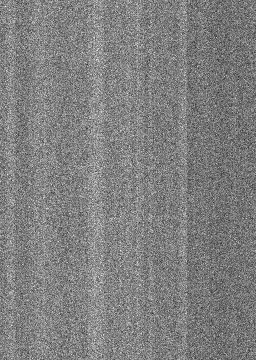

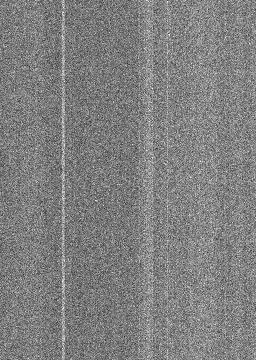

In [4]:
if DEBUG:
    f1, f2 = df_noise.iloc[42].files
    display(Image.open(f1))
    display(Image.open(f2))

In [5]:
df_signal = pd.DataFrame(data=[[f] + list(re.findall('.*/(.*)_(.*).png', f)[0]) for f in glob.glob(f'{SIGNAL_DIR}/*')], columns=['name', 'id', 'detector']).sort_values(['id', 'detector'])
df_signal = df_signal.groupby('id').filter(lambda df: len(df) == 2).groupby('id', sort=False).apply(lambda df: df['name'].values).to_frame('files').reset_index()
df_signal_train, df_signal_eval = np.array_split(df_signal, [int(len(df_signal) * 0.9)])
df_signal

,id,files
0,00000,"[../input/pure_signal/00000_H1.png, ../input/p..."
1,00001,"[../input/pure_signal/00001_H1.png, ../input/p..."
2,00002,"[../input/pure_signal/00002_H1.png, ../input/p..."
3,00003,"[../input/pure_signal/00003_H1.png, ../input/p..."
4,00004,"[../input/pure_signal/00004_H1.png, ../input/p..."
...,...,...
9550,09995,"[../input/pure_signal/09995_H1.png, ../input/p..."
9551,09996,"[../input/pure_signal/09996_H1.png, ../input/p..."
9552,09997,"[../input/pure_signal/09997_H1.png, ../input/p..."
9553,09998,"[../input/pure_signal/09998_H1.png, ../input/p..."


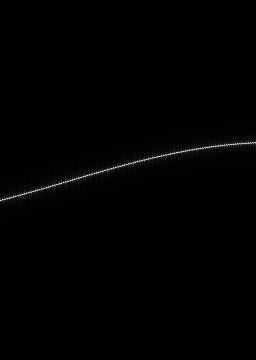

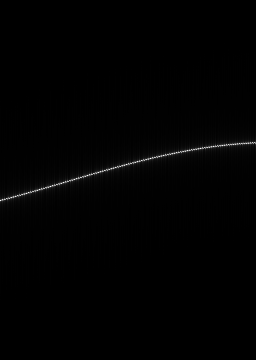

In [6]:
if DEBUG:
    f1, f2 = df_signal.iloc[42].files
    display(Image.open(f1))
    display(Image.open(f2))

In [7]:
transforms_time_mask = nn.Sequential(
                torchaudio.transforms.TimeMasking(time_mask_param=10),
            )

transforms_freq_mask = nn.Sequential(
                torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
            )
time_mask_num = 3 # number of time masking
freq_mask_num = 3 # number of frequency masking
negative_flip_prob = 0.5
ligo_swap_prob = 0.5
time_mask_prob = 0.5
freq_mask_prob = 0.5

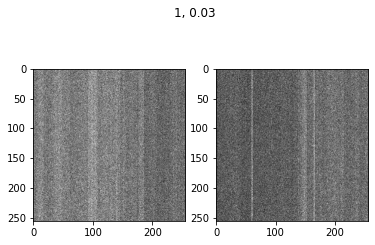

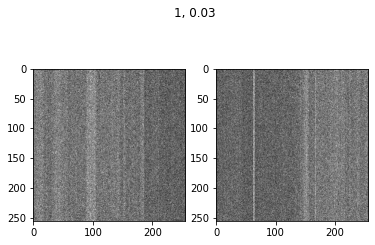

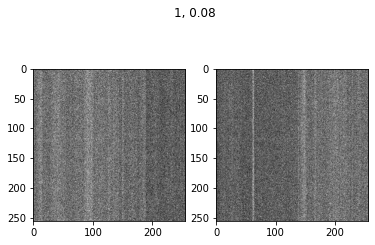

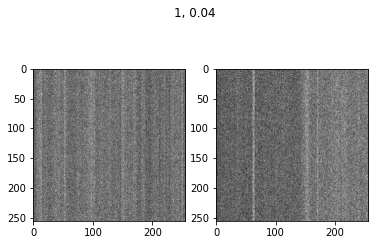

In [8]:
from collections import defaultdict
import re

def get_transforms():
    return torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=0.5, std=0.1),
            torchvision.transforms.Resize((256, 256))
        ])


class RealisticNoiseDataset(Dataset):
    def __init__(self, size, df_noise, df_signal, positive_rate=POSITIVE_RATE, is_train=False) -> None:
        self.df_noise = df_noise
        self.df_signal = df_signal
        self.positive_rate = positive_rate
        self.size = size
        self.transforms = get_transforms()
        self.is_train = is_train
       


    def gen_sample(self, signal, noise, signal_strength):
        noise = np.array( Image.open(noise))  
        targ= 0
        if signal:
            targ = 1
            signal = np.array( Image.open(signal)) 
            noise = noise + signal_strength * signal


        if self.is_train:
            if GAUSSIAN_NOISE > 0:
                noise = noise + np.random.randn(*noise.shape) * GAUSSIAN_NOISE 
            #if np.random.rand() > negative_flip_prob and targ ==0:
            #   noise = noise[:, ::-1].copy()
            if np.random.rand() > ligo_swap_prob:
                w0 = noise[0].copy()
                noise[0] = noise[1]
                noise[1] = w0
            

        noise = np.clip(noise, 0, 255).astype(np.uint8)
        #print(noise.shape)
        noise = self.transforms(noise)
        #print(noise.shape)
        if self.is_train:
            if np.random.rand() > time_mask_prob: 
                for _ in range(time_mask_num): 
                        noise = transforms_time_mask(noise)
            if np.random.rand() > freq_mask_prob:     
                for _ in range(freq_mask_num):  
                        noise = transforms_freq_mask(noise)
                
        return  noise


    def __getitem__(self, index):
        noise_files = self.df_noise.sample().files.values[0]
        
        sig_files = [None, None]
        label = 0
        if np.random.random() < self.positive_rate:
            sig_files = self.df_signal.sample().files.values[0]
            label = 1
        signal_strength = np.random.uniform(SIGNAL_LOW, SIGNAL_HIGH)                    
        return np.concatenate([self.gen_sample(sig, noise, signal_strength) for sig, noise in zip(sig_files, noise_files)], axis=0), label, signal_strength


    def __len__(self):
        return self.size



ds_eval = RealisticNoiseDataset(
    len(df_signal_eval), 
    df_noise_eval,
    df_signal_eval
)
dl_eval = torch.utils.data.DataLoader(ds_eval, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), pin_memory=True)

if DEBUG:
    for i in range(4):
        X, y, ss = ds_eval[i]
        plt.figure()
        plt.suptitle(f'{y}, {ss:.02f}')
        plt.subplot(121).imshow(X[0], cmap='gray')
        plt.subplot(122).imshow(X[1], cmap='gray')

Eval: 100%|██████████| 120/120 [00:06<00:00, 17.42it/s]


0.4766106442577031 0.6942054629325867


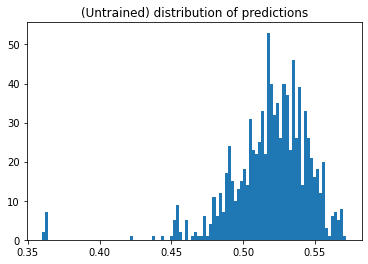

In [9]:
def evaluate(model, dl_eval, return_X=False):
    with torch.no_grad():
        model.eval()
        pred = []
        target = []
        ss = []
        signal_strength = []
        Xs = []
        for X, y, ss in tqdm(dl_eval, desc='Eval'):
            
            pred.append(model(X.to(DEVICE)).cpu().squeeze())
            target.append(y)
            signal_strength.append(ss)
            if return_X:
                Xs.append(X)
        pred = torch.concat(pred)
        target = torch.concat(target)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, target.float(), reduction='none').median().item() # Avoiding outlier loss with median
        pred = torch.sigmoid(pred)
        ret = [roc_auc_score(target, pred), loss, pred, target, torch.concat(signal_strength).numpy()]
        if return_X:
            ret.append(torch.concat(Xs).numpy())
        return ret
    
if DEBUG:
    auc, loss, pred, target, ss, X = evaluate(timm.create_model('inception_v4', pretrained=True, num_classes=1, in_chans=2).to(DEVICE), dl_eval, return_X=True)
    print(auc, loss)
    plt.title('(Untrained) distribution of predictions')
    _ = plt.hist(pred, bins=100)

In [10]:
def train(model, dl_train, epoch, run, optim, scheduler):
    for step, (X, y, ss) in enumerate(tqdm(dl_train, desc='Train')):
        pred = model(X.to(DEVICE)).squeeze()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, y.float().to(DEVICE))
        if step %100 ==0:
            print(step/len(dl_train))
         
        index = torch.randperm(BATCH_SIZE).cuda()
        wave1 = X[index]
         
        for b in range(BATCH_SIZE):
                        if np.random.rand() >0.5:
                            X[:, 0:4096:2] =  wave1[:, 0:4096:2]
         
        optim.zero_grad()
        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optim.step()
        del X
        if scheduler:
            scheduler.step()
        if run:
            run.log({
                'step': step,
                'loss': loss.item(),
                'lr': scheduler.get_last_lr()[0] if scheduler else LR,
                'grad_norm': norm,
                'epoch': epoch,
                'logit': pred.mean().item()
            })
        #break    

In [11]:
from sklearn.model_selection import KFold

In [13]:
def get_dl(fold):
    kfold = KFold(N_FOLDS, shuffle=True, random_state=42)
    df_noise_train, df_noise_eval = None, None
    for f, (train_idx, eval_idx) in enumerate(kfold.split(df_noise)):
        if f == fold:
            df_noise_train = df_noise.loc[train_idx]
            df_noise_eval = df_noise.loc[eval_idx]

    df_signal_train, df_signal_eval = None, None
    for f, (train_idx, eval_idx) in enumerate(kfold.split(df_signal)):
        if f == fold:
            df_signal_train = df_signal.loc[train_idx]
            df_signal_eval = df_signal.loc[eval_idx]

    ds_train = RealisticNoiseDataset(
        len(df_signal_train), 
        df_noise_train,
        df_signal_train,
        is_train=True
    )

    ds_eval = RealisticNoiseDataset(
        len(df_signal_eval), 
        df_noise_eval,
        df_signal_eval
    )

    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
    dl_eval = torch.utils.data.DataLoader(ds_eval, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), pin_memory=True)
    return dl_train, dl_eval

if DEBUG:
    dl_train, dl_eval = get_dl(0)
    for v in dl_train:
        print(v)
        break

[tensor([[[[-2.3468e-01, -1.7157e-01, -7.4449e-01,  ...,  3.3272e-01,
            5.4412e-01, -1.8321e-01],
          [ 3.7378e-02, -9.9326e-01,  3.6397e-01,  ..., -1.7757e+00,
           -6.4338e-02,  7.4326e-01],
          [ 4.5895e-01, -2.4877e-01,  1.3578e+00,  ...,  3.8726e-01,
           -1.5196e-01, -1.5987e+00],
          ...,
          [ 4.7978e-01,  1.2745e+00, -8.5784e-02,  ..., -2.0833e-02,
           -2.3211e+00, -7.8983e-01],
          [-3.7990e-02,  6.4583e-01,  7.0466e-02,  ..., -8.6458e-01,
           -4.8468e-01,  1.0938e+00],
          [ 2.5245e-01,  8.0944e-01,  2.0833e-02,  ..., -1.0098e+00,
            6.8627e-01,  1.8015e-01]],

         [[-1.2849e+00, -8.1985e-01, -2.9963e-01,  ...,  3.7378e-02,
            1.1134e+00,  1.2855e+00],
          [-3.2353e-01, -2.6103e-01, -1.3713e+00,  ...,  1.6201e+00,
            8.0821e-01,  4.3260e-01],
          [ 1.2402e+00,  6.8566e-01, -9.1238e-01,  ..., -5.1471e-02,
            5.1103e-01,  6.4216e-01],
          ...,
    

In [13]:
def run_training(run=None, fold=0):
    dl_train, dl_eval = get_dl(fold)

    model = timm.create_model(MODEL, pretrained=True, num_classes=1, in_chans=2, drop_rate=DROPOUT).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = None
    if ONE_CYCLE:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optim, max_lr=LR, total_steps=len(dl_train) * EPOCHS, pct_start=ONE_CYCLE_PCT_START)


    max_auc = 0
    patience = 0
    max_patience = 5
    for epoch in range(EPOCHS):
        train(model, dl_train, epoch, run, optim, scheduler)
        auc, loss = evaluate(model, dl_eval)[:2]
        if auc > max_auc:
            !mkdir -p models
            torch.save(model.state_dict(), f'models/model-f{fold}.tph')
            max_auc = auc
            patience = 0
            print(auc)
        else:
            patience = patience + 1
        if patience >max_patience:
                print("early stopping")
                break 
        if run:
            run.log({
                'val_loss': loss,
                'val_auc': auc,
                'val_max_auc': max_auc
            })
    del model, optim, scheduler
    torch.cuda.empty_cache()
    gc.collect()
    return max_auc

if TRAIN:
    for fold in FOLDS:
         
        with wandb.init(project='g2net', name=f'{WANDB_RUN}-f{fold}', group=WANDB_RUN) as run:
            run_training(run, fold=fold)
            torch.cuda.empty_cache()
            gc.collect()


wandb: Currently logged in as: rmvinogradov. Use `wandb login --relogin` to force relogin


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:51,  2.59it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:14,  2.58it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:34,  2.59it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.59it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:30<01:39,  2.57it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:08<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:47<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.71it/s]


0.8781114854947049


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:29,  2.59it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:08<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.60it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.72it/s]


0.8899508621067872


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:30,  2.59it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:56<04:12,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:13<02:55,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:30<01:42,  2.48it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:09<00:59,  2.59it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:47<00:21,  2.60it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:56<04:12,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:13<02:57,  2.57it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:30<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:08<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:47<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:29,  2.59it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.62it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.80it/s]


0.8969952568217419


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:15,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.60it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:26,  2.62it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:12,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:51,  2.59it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:12,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.62it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:30,  2.59it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:10<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:48<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.74it/s]


early stopping


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
grad_norm,▂▃▂▃▁▁█▂▂▁▂▁▂▂▂▂▂▁▂▁▂▃▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
logit,▁▁▃▃▂▆▇▄▃▅▃▄▁▂▅▃▆▂▆▂▅▄▄▁▁▆▂▄▃▃▄▆▃▄▂█▃▃▃▄
loss,▆▆▆▄▂▁▅▂▇▂▂▁▇▅▃▃▃▂▃▃█▃▃▅▅▁▄▂▃▂▂▁▂▃▄▂▂▂▁▃
lr,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██████████
step,▂▄▆█▂▄▆▁▃▅▇▂▃▆▁▃▅▇▂▄▅▇▂▄▆█▄▅▇▂▄▆█▃▅▇▁▃▅█
val_auc,▃▆▆▆█▇▂▆▁▅
val_loss,█▂▅▄▂▃▂▁▅▆
val_max_auc,▁▅▅▅██████
epoch,10
grad_norm,0.92112


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:26,  2.62it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:16<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.62it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.60it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.78it/s]


0.8814955139842662


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.59it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.80it/s]


0.8978017571041312


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.62it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.78it/s]


0.9058102468040357


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.62it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.62it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.60it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:48,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.60it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.62it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.62it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.62it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.62it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.62it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.62it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.79it/s]


early stopping


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
grad_norm,▂▄▃▂▄▃▃▃▂▂█▃▂▁▄▂▂▂▁▃▂▂▁▃▂▃▁▁▂▁▂▁▃▁▁▁▂▁▁▁
logit,▃▄▅▂▅▂▂▂▃▃▇▁▆▄▇▃█▂▃▂▂▆▁▇▄▅▇▆▁▅▃▃▃▆▄▅▅▄▆▃
loss,▆▇▅▂▅▃▅▅▂▄▄▆▃▁▃▃▂▅▁▇▆▂▁▄█▅▂▁▁▁▃▃▅▁▂▃▃▁▂▁
lr,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
step,▂▃▅▇█▂▄▅▇▂▃▅▇▁▂▄▆▇▂▄▅▇▁▂▄▆▁▂▄▆▇▂▄▅▆▁▂▄▆█
val_auc,▃▆█▆▃▄▁▄
val_loss,█▅▁▁▅▆▂▁
val_max_auc,▁▆██████
epoch,8
grad_norm,2.35492


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:26,  2.62it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:16<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:11<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:06<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.84it/s]


0.8446523654052632


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.62it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.62it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.78it/s]


0.8944439089152466


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:26,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:48,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.60it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.80it/s]


0.9130412392595822


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:12,  2.59it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:53,  2.62it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.62it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.62it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:26,  2.62it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.62it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.62it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.62it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:53,  2.62it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.62it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:26,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.62it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.82it/s]


early stopping


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
grad_norm,▂▁▁▁▂▂█▅▅▃▃▃▃▄▄▃▃▅▃▃▂▅▃▁▃▁▂▂▃▁▁▂▃▄▂▁▂▁▁▁
logit,▂▂▃▃▂▃▇▅▃▆▅▅▅▅▆▄▇▆▄▅▃▆▄▆▄▃▄▆▁▅▇▃█▂▃▁▄▄▄▄
loss,▇███▇▄▄▃▄▂▃▂▂▅▃▂▃█▇▃▂▅▅▂▄▁▄▃▇▁▁▄▂▄▅▁▄▁▁▂
lr,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
step,▂▃▅▇█▂▄▅▇▂▃▅▇▁▂▄▆▇▂▄▅▇▁▂▄▆▁▂▄▆▇▂▄▅▆▁▂▄▆█
val_auc,▁▆█▆▆▃▆▅
val_loss,█▂▁▂▁▂▁▂
val_max_auc,▁▆██████
epoch,8
grad_norm,2.32896


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:16<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.80it/s]


0.8770092851711193


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.59it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.81it/s]


0.9033514498706432


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:29,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.62it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.62it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.60it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:48,  2.62it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:13,  2.59it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:31<01:42,  2.49it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:12<00:59,  2.59it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:52<00:21,  2.52it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.82it/s]


early stopping


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
grad_norm,▃▂▇▅█▂▂▃▁▂▅▃▁▆▃▄▃▁▂▃▂▄▁▂▄▁▂▃▂▃▂▃▂▂▂▂▂▃▃▁
logit,▃▂▃▄▁▁▁▅▆▅▆▇▃▄▆▅▆▆▂▂▅▄█▆▆▂▃▄▇▁▄▂▇▇▂▃▂▃▃▄
loss,██▆▄▆▂▅▂▁▄▆▃▁▅▂▄▅▁▂▃▄▃▁▂▄▁▁▃▄▃▃▂▄▂▅▂▃▇▅▂
lr,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
step,▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆▇▁▃▄▆█
val_auc,▁█▃▅▃▅▃
val_loss,█▃▂▃▇▃▁
val_max_auc,▁██████
epoch,7
grad_norm,3.54527


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:26,  2.62it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:57<04:37,  2.36it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:39<03:46,  2.45it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:19<02:56,  2.57it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:59<02:15,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:40<01:40,  2.54it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:20<00:59,  2.59it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:58<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.82it/s]


0.8787440185616477


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:48,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:53,  2.62it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.85it/s]


0.8945691451712221


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:27,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:55<03:12,  1.85it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:49<02:17,  1.86it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:42<01:23,  1.85it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [06:33<00:20,  2.67it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:26,  2.62it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:33<03:32,  2.62it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:15,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:28<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:22,  2.49it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:29,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:56<04:12,  2.59it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:13<02:55,  2.59it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:51<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:30<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:08<00:59,  2.59it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:47<00:21,  2.60it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.84it/s]


0.897179919801915


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:50,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:33,  2.60it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.60it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.60it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:10,  2.62it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.60it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.61it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:38,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.61it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.60it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:38<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.61it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.62it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:54,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.61it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:45<00:21,  2.61it/s]

0.9424083769633508


Train:   0%|          | 0/955 [00:00<?, ?it/s]

0.0


Train:  10%|█         | 100/955 [00:39<05:28,  2.61it/s]

0.10471204188481675


Train:  21%|██        | 200/955 [01:17<04:49,  2.61it/s]

0.2094240837696335


Train:  31%|███▏      | 300/955 [01:55<04:11,  2.60it/s]

0.31413612565445026


Train:  42%|████▏     | 400/955 [02:34<03:32,  2.61it/s]

0.418848167539267


Train:  52%|█████▏    | 500/955 [03:12<02:55,  2.60it/s]

0.5235602094240838


Train:  63%|██████▎   | 600/955 [03:50<02:16,  2.61it/s]

0.6282722513089005


Train:  73%|███████▎  | 700/955 [04:29<01:37,  2.60it/s]

0.7329842931937173


Train:  84%|████████▍ | 800/955 [05:07<00:59,  2.60it/s]

0.837696335078534


Train:  94%|█████████▍| 900/955 [05:46<00:21,  2.61it/s]

0.9424083769633508


Eval: 100%|██████████| 239/239 [00:18<00:00, 12.81it/s]


early stopping


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
grad_norm,▃▅▇▃▅▅▄▃▆▆▄▄▇█▃▇▃▄▂▂▅▄▃▂▂▃▃▂▂▇▂▁▂▃▂▃▁▂▂▂
logit,▂▃▃▄▄▃▅▃▁▂▃▅▃▄▂▆▄▅▄▂▄▅▂▂█▄▄▃▂▇▃█▃▅▄▃▄▄▄▇
loss,▇▅▇▂▄▅▃▄▅▆▄▂▇▅▂▅▃▂▃▂▃▆█▂▃▃▄▃▂▆▃▁▄▂▂▃▁▃▄▂
lr,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇██████████
step,▂▄▆█▂▄▆▁▃▅▇▂▃▆▁▃▅▇▂▄▅▇▂▄▆█▄▅▇▂▄▆█▃▅▇▁▃▅█
val_auc,▁▇▅▁█▅▂▁▂▁
val_loss,█▇▅▅▁▂▄▅▇▆
val_max_auc,▁▇▇▇██████
epoch,10
grad_norm,0.36529


In [14]:
def load_model(fold=0):
    model = timm.create_model(MODEL, pretrained=False, num_classes=1, in_chans=2).to(DEVICE)
    model.load_state_dict(torch.load(f'models/model-f{fold}.tph'))
    model.eval()
    return model
    
model = load_model()

In [17]:
import pandas as pd
df_test = pd.read_csv('../input/test.csv').query('is_generated_noise == False')
df_test

,id,is_generated_noise
3,42a3b2de1,False
6,4ec4b6776,False
7,1031d1f36,False
11,79a0e8448,False
16,6d16d5a37,False
...,...,...
7951,abb05d238,False
7954,e963d2358,False
7956,1ae654ef8,False
7960,a8591701b,False


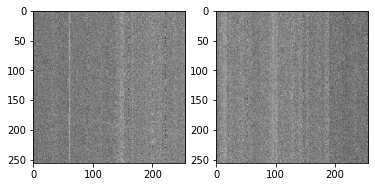

In [18]:
class G2NETDataset(Dataset):
    def __init__(self, df, image_path) -> None:
        self.df = df
        self.image_path = image_path
        self.transforms = get_transforms()

    def __getitem__(self, index):
        id = self.df.iloc[index].id
         
        #im1 = self.transforms(Image.open(f'{self.image_path}/{id}_h1.png'))
        #im2 = self.transforms(Image.open(f'{self.image_path}/{id}_l1.png'))
        
        im1 = np.array( Image.open(f'{self.image_path}/{id}_h1.png')) 
        im2 = np.array( Image.open(f'{self.image_path}/{id}_l1.png')) 
        
        if np.random.rand() > ligo_swap_prob:
                w0 = im1.copy()
                im1 = im2
                im2 = w0
                
        im1 = self.transforms(im1)
        im2 = self.transforms(im2)
        
        
        if np.random.rand() > time_mask_prob: 
            for _ in range(time_mask_num): 
                  
                   im1 = transforms_time_mask(im1)
                   im2 = transforms_time_mask(im2) 
        if np.random.rand() > freq_mask_prob:     
                for _ in range(freq_mask_num):                     
                    im1 = transforms_freq_mask(im1)
                    im2 = transforms_freq_mask(im2)
        """               
        if np.random.rand() > ligo_swap_prob:
                w0 = im1.copy()
                im1 = im2
                im2 = w0
        """ 
      
        return np.concatenate([im1,im2])
    def __len__(self):
        return len(self.df)



ds_test = G2NETDataset(df_test, 'data/test_png/')

if DEBUG:
    X = ds_test[42]
    plt.subplot(121).imshow(X[0], cmap='gray')
    plt.subplot(122).imshow(X[1], cmap='gray')

In [19]:
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())


with torch.no_grad():
    fold_preds = []
    for fold in tqdm(FOLDS, desc='Fold prediction'):
        gc.collect()
        torch.cuda.empty_cache()
        
        model = load_model(fold)
        preds1 = torch.concat([torch.sigmoid(model(X.to(DEVICE))).cpu() for X in tqdm(dl_test)], dim=0).numpy()
        ds_test = G2NETDataset(df_test, 'data/test_png/')
        dl_test = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
        preds2= torch.concat([torch.sigmoid(model(X.to(DEVICE))).cpu() for X in tqdm(dl_test)], dim=0).numpy()
        ds_test = G2NETDataset(df_test, 'data/test_png/')
        dl_test = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
        preds3= torch.concat([torch.sigmoid(model(X.to(DEVICE))).cpu() for X in tqdm(dl_test)], dim=0).numpy()
        ds_test = G2NETDataset(df_test, 'data/test_png/')
        dl_test = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
        preds4= torch.concat([torch.sigmoid(model(X.to(DEVICE))).cpu() for X in tqdm(dl_test)], dim=0).numpy()
        ds_test = G2NETDataset(df_test, 'data/test_png/')
        dl_test = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
        preds5= torch.concat([torch.sigmoid(model(X.to(DEVICE))).cpu() for X in tqdm(dl_test)], dim=0).numpy()
        preds = (preds1 + preds2 + preds3 + preds4 + preds5)/5
        #preds = preds1
        fold_preds.append(preds)

preds = np.stack(fold_preds).squeeze().mean(axis=0)

100%|██████████| 188/188 [00:14<00:00, 12.69it/s]

100%|██████████| 188/188 [00:14<00:00, 12.79it/s]

100%|██████████| 188/188 [00:14<00:00, 12.78it/s]

 26%|██▌       | 49/188 [00:04<00:10, 13.08it/s]


100%|██████████| 188/188 [00:14<00:00, 12.75it/s]

100%|██████████| 188/188 [00:14<00:00, 12.63it/s]

 54%|█████▎    | 101/188 [00:08<00:06, 12.98it/s]


100%|██████████| 188/188 [00:14<00:00, 12.67it/s]

100%|██████████| 188/188 [00:14<00:00, 12.65it/s]

100%|██████████| 188/188 [00:14<00:00, 12.62it/s]

 82%|████████▏ | 155/188 [00:12<00:02, 12.90it/s]


100%|██████████| 188/188 [00:14<00:00, 12.63it/s]

100%|██████████| 188/188 [00:14<00:00, 12.58it/s]

100%|██████████| 188/188 [00:14<00:00, 12.59it/s]

  9%|▉         | 17/188 [00:01<00:13, 12.45it/s]


100%|██████████| 188/188 [00:14<00:00, 12.60it/s]

100%|██████████| 188/188 [00:14<00:00, 12.59it/s]

 37%|███▋      | 69/188 [00:05<00:09, 12.90it/s]


100%|██████████| 188/188 [00:14<00:00, 12.61it/s]

100%|██████████| 188/188 [00:15<00:00, 12.50it/s]

100%|██████████| 188/188 [00:14<00:00, 12.59it/s]

 65%|██████▌   | 123/188 [00:09<00:05, 12.86it/s]


100%|██████████| 188/188 [00:14<00:00, 12.58it/s]

100%|██████████| 188/188 [00:14<00:00, 12.57it/s]

 93%|█████████▎| 175/188 [00:13<00:01, 12.89it/s]


100%|██████████| 188/188 [00:14<00:00, 12.58it/s]

100%|██████████| 188/188 [00:14<00:00, 12.58it/s]

 58%|█████▊    | 109/188 [00:08<00:06, 12.86it/s]


Fold prediction: 100%|██████████| 5/5 [06:20<00:00, 76.02s/it]


In [20]:
df_test['target'] = preds
df_test

,id,is_generated_noise,target
3,42a3b2de1,False,0.142914
6,4ec4b6776,False,0.096760
7,1031d1f36,False,0.140790
11,79a0e8448,False,0.074036
16,6d16d5a37,False,0.062726
...,...,...,...
7951,abb05d238,False,0.076046
7954,e963d2358,False,0.057523
7956,1ae654ef8,False,0.074464
7960,a8591701b,False,0.161385


<AxesSubplot: ylabel='Frequency'>

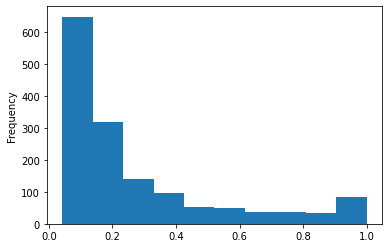

In [21]:
df_test.target.plot.hist()

In [22]:
df_sub = pd.read_csv('blend2.csv').set_index('id')#761
df_sub.loc[df_test.id, 'target'] =  (df_test.set_index('id').target + df_sub.loc[df_test.id, 'target']) / 2
df_sub

,target
id,
00054c878,0.239803
0007285a3,0.615324
00076c5a6,0.228886
001349290,0.276913
001a52e92,0.384574
...,...
ffbce04ef,0.698621
ffc2d976b,0.233689
ffc905909,0.203972


In [23]:
df_sub.to_csv('submission.csv')

In [24]:
#df_sub.to_csv('submission.csv')

In [1]:
import timm
all_densenet_models = timm.list_models('*convnext*')
all_densenet_models

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']